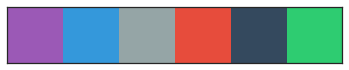

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, gridspec
from matplotlib.lines import Line2D
bpz_dir = '/Users/bl/Dropbox/software/bpz-1.99.3'
from scipy.interpolate import interp1d
import sys
sys.path.append("/Users/bl/Dropbox/software/bpz-1.99.3")
from bpz_tools import lf_z_sed
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_style("white")
sns.palplot(sns.color_palette(flatui))
sns.set_palette(sns.color_palette(flatui))
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=None)
DL = cosmo.luminosity_distance
import camb
from camb import model, initialpower

Note: redshifts have been re-sorted (earliest first)
3303.52645304 Mpc


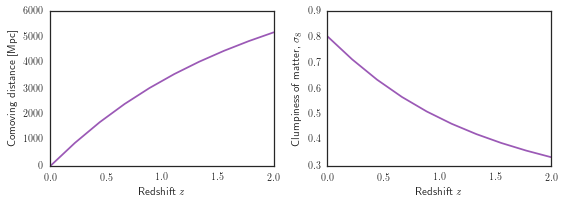

In [2]:
pars = camb.CAMBparams()
redshiftGrid = np.linspace(0, 2, num=10)
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=redshiftGrid, kmax=2.0)
pars.NonLinear = model.NonLinear_none #Linear spectra
results = camb.get_results(pars)
s8 = np.array(results.get_sigma8())

redshiftGrid = np.linspace(0, 2, num=10)
print cosmo.comoving_distance(1)
dist = [cosmo.comoving_distance(z).value for z in redshiftGrid]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(redshiftGrid, dist)
ax[0].set_xlabel('Redshift $z$')
ax[0].set_ylabel('Comoving distance [Mpc]')

ax[1].plot(redshiftGrid, s8[::-1])
ax[1].set_xlabel('Redshift $z$')
ax[1].set_ylabel('Clumpiness of matter, $\sigma_8$')

fig.tight_layout()
fig.savefig('sig8redshift.pdf')

(2000.0, 11000.0)

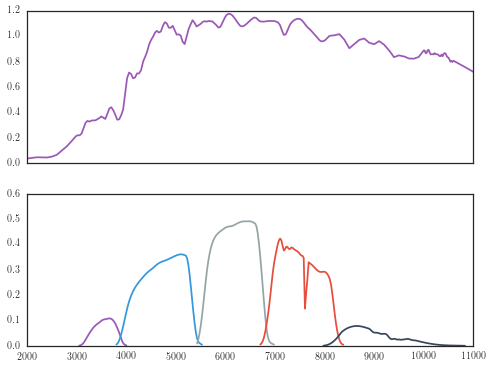

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ab_filters = ['u', 'g', 'r', 'i', 'z']
numBands = len(ab_filters)
tabulatedfilters = [np.genfromtxt(bpz_dir+'/FILTER/'+band+'.res') for band in ab_filters]
lambdaMinMax_arr = np.zeros((numBands, 2))
filter_interpolators = np.zeros((numBands,), dtype=object)
for i, (band, data) in enumerate(zip(ab_filters, tabulatedfilters)):
    x, y = data[:,0], data[:,1]
    ind = np.where(y > 0.01*np.max(y))[0]
    lambdaMin, lambdaMax = x[ind[0]], x[ind[-1]]
    lambdaMinMax_arr[i,:] = lambdaMin, lambdaMax
    filter_interpolators[i] = interp1d(x[ind], y[ind], fill_value='extrapolate')
    axs[1].plot(x[ind], y[ind])
axs[1].set_ylim([0, 0.6])

template_names = ['El_B2004a']#, 'Sbc_B2004a', 'Scd_B2004a']
#, 'Im_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']
numTemplates = len(template_names)
lambdaRef = 4.5e3
template_interpolators = np.zeros((numTemplates,), dtype=object)
for it, template_name in enumerate(template_names):
    data = np.genfromtxt(bpz_dir+'/SED/'+template_name+'.sed')
    ref = np.interp(lambdaRef, data[:,0], data[:,1])
    template_interpolators[it] = interp1d(data[:,0], data[:,1] / ref, fill_value='extrapolate')
    axs[0].plot(data[:,0], data[:,1])
axs[0].set_xlim([2e3, 1.1e4])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

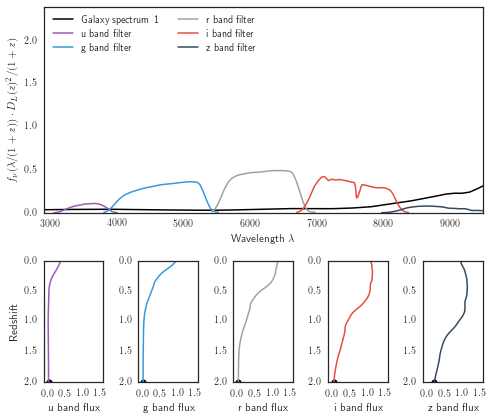

In [8]:
palette = sns.color_palette()
linestyles = ['solid', 'dashdot', 'dotted']
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        redshiftMax = 2.0
        self.redshiftGrid = np.linspace(0, redshiftMax, num=100)
        lambdaMinAbs, lambdaMaxAbs = 2.9e3, 0.95e4
        fig = plt.figure(figsize=(7, 6))
        gs = gridspec.GridSpec(5, 5)
        lw = 1.5
        ax1 = fig.add_subplot(gs[0:3, 0:])
        #ax1.set_yticks([])
        ax1.set_xlim([lambdaMinAbs, lambdaMaxAbs])
        #ax1.set_ylim([1e-2, 1e4])
        #ax1.set_yscale('log')
        ax1.set_ylim([0, 2.4])
        ax1.set_xlabel(r'Wavelength $\lambda$')
        ax1.set_ylabel(r'$f_\nu(\lambda/(1+z)) \cdot D_L(z)^2 / (1+z)$')
        axb1 = fig.add_subplot(gs[3:, 0])
        axb2 = fig.add_subplot(gs[3:, 1])
        axb3 = fig.add_subplot(gs[3:, 2])
        axb4 = fig.add_subplot(gs[3:, 3])
        axb5 = fig.add_subplot(gs[3:, 4])
        axs = [axb1, axb2, axb3, axb4, axb5]
        self.lines = [[ax1.plot([], [], lw=lw, c='k', ls=linestyles[it], label='Galaxy spectrum '+str(it+1))[0]]
            + [ax.plot([], [], ls=linestyles[it], lw=lw, color=palette[i])[0] for i, ax in enumerate(axs)] for it in range(numTemplates)]
        self.points = [[ax.scatter([], [], lw=lw) for ax in axs] for it in range(numTemplates)]
        self.xl = np.linspace(lambdaMinAbs/(1+redshiftMax), lambdaMaxAbs, num=2000)
        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)
        self.templates = [template_interpolators[it](self.xl) for it in range(numTemplates)]
        
        for i in range(numBands):
            x = np.linspace(lambdaMinMax_arr[i,0], lambdaMinMax_arr[i,1], num=100)
            ax1.plot(x, filter_interpolators[i](x), color=palette[i], label=ab_filters[i]+' band filter', lw=lw)
        lg = ax1.legend(loc='upper left', frameon=False, ncol=2)
        
        self.f_mod = np.zeros((self.redshiftGrid.size, numTemplates, numBands))
        for it in range(numTemplates):
            for ib, ax in enumerate(axs):
                y = 0*self.redshiftGrid
                xf = np.linspace(lambdaMinMax_arr[ib,0], lambdaMinMax_arr[ib,1], num=200)
                for iz, z in enumerate(self.redshiftGrid):
                    yf = filter_interpolators[ib](xf)
                    ysed = template_interpolators[it](xf/(1.+z))
                    norm = np.trapz(yf, x=xf/(1.+z))
                    Dval = DL(z).value / 1e4
                    self.f_mod[iz,it,ib] = np.trapz(ysed*yf, x=xf/(1.+z)) / norm # * (1+z)/Dval**2.0
        for ib, ax in enumerate(axs):
            ax.set_ylim([redshiftMax, 0])
            ax.set_xlim([-0.1, 1.6])
            ax.set_xticks([0, 0.5, 1.0, 1.5]) 
            ax.set_xlabel(ab_filters[ib]+' band flux')            
            if ib == 0:
                ax.set_ylabel('Redshift')
            #else:
            #    ax.set_yticks([])    
        fig.tight_layout()
        
        
    def _draw_frame(self, framedata):
        print framedata,
        i = framedata
        z = np.max([1e-2, self.redshiftGrid[i]])
        Dval = DL(z).value / 1e4
        #print z, DL(z).value, Dval, (1+z)/Dval**2 
        for it in range(numTemplates):
            lineM = self.lines[it][0]
            lineM.set_data(self.xl*(1.+z), self.templates[it] )  # * (1+z)/Dval**2.0
            for ib, line in enumerate(self.lines[it][1:]):
                line.set_data(self.f_mod[:i+1,it,ib], self.redshiftGrid[:i+1])
                self.points[it][ib].set_offsets([self.f_mod[i,it,ib], self.redshiftGrid[i]])
        self._drawn_artists = self.lines

    def new_frame_seq(self):
        return iter(range(self.redshiftGrid.size))

    def _init_draw(self):
        for it in range(numTemplates):
            for l in self.lines[it]:
                l.set_data([], [])

ani = SubplotAnimation()
ani.save('Template_photoz_fluxes'+str(numTemplates)+'.mp4', dpi=300)
plt.show()